# **Exploratory Data Analysis**

In [1]:
from pathlib import Path
from typing import Dict, Optional
import pandas as pd
import json

In [2]:
demo = pd.read_csv('data/Demographics.csv')
demo

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


In [3]:
import pandas as pd
from datetime import timedelta
import json

In [4]:
# Adjust path as needed
glucose = pd.read_json("data/flattened_glucose.json")

# Convert timestamp column to datetime
glucose["timestamp"] = pd.to_datetime(glucose["timestamp"])

# Confirm column names
glucose.head()

,patient_id,timestamp,glucose
0,1,2020-02-13 17:23:32,61
1,1,2020-02-13 17:28:32,59
2,1,2020-02-13 17:33:32,58
3,1,2020-02-13 17:38:32,59
4,1,2020-02-13 17:43:31,63


In [5]:
# Spikey meal: Participant 10 on 2020-03-29 at 12:50
# Flat meal:   Participant 12 on 2020-05-06 at 08:55

meals = [
    {"label": "spikey", "pid": 10, "meal_time": pd.Timestamp("2020-03-29 12:50")},
    {"label": "flat", "pid": 12, "meal_time": pd.Timestamp("2020-05-06 08:55")}
]

In [6]:
def extract_glucose_trace(glucose_df, pid, meal_time, pre=30, post=120):
    df = glucose_df[glucose_df["patient_id"] == pid].copy()
    
    window = df[
        (df["timestamp"] >= meal_time - timedelta(minutes=pre)) &
        (df["timestamp"] <= meal_time + timedelta(minutes=post))
    ].copy()
    
    # Calculate minutes since meal
    window["minutes"] = (window["timestamp"] - meal_time).dt.total_seconds() / 60
    window = window[["minutes", "glucose"]].round(2).sort_values("minutes")
    
    return window.to_dict(orient="records")

In [7]:
# Create a dictionary with both traces
traces = {}

for meal in meals:
    traces[meal["label"]] = extract_glucose_trace(
        glucose_df=glucose,
        pid=meal["pid"],
        meal_time=meal["meal_time"]
    )

# Save to JSON
with open("glucose_intro_traces.json", "w") as f:
    json.dump(traces, f, indent=2)

print("Saved to glucose_intro_traces.json ✅")

Saved to glucose_intro_traces.json ✅


| **HbA1c (%)**         | **Interpretation**              |
|----------------------|----------------------------------|
| Below 5.7%           | Normal / Non-Diabetic            |
| 5.7% to 6.4%         | Prediabetes                      |
| 6.5% or higher       | Diabetes                         |


All participants in our dataset seem to be mostly prediabetic and normal-ish.

## 🩸 Understanding HbA1c: A Marker of Long-Term Glucose Control

**HbA1c** (glycated hemoglobin) reflects the average blood glucose level over the past **2 to 3 months**. It's a standard biomarker used in clinical settings to assess metabolic health and diagnose diabetes.



### 📊 HbA1c Ranges and Their [Clinical Interpretation](https://diabetes.org/about-diabetes/a1c)

| **HbA1c (%)**     | **Interpretation**                                      |
|------------------|----------------------------------------------------------|
| **4.6% – 5.2%**   | Excellent control — very healthy, often athletic individuals |
| **5.3% – 5.6%**   | Normal glycemic control — healthy general population     |
| **5.7% – 6.4%**   | Prediabetic — elevated risk for Type 2 Diabetes          |
| **≥ 6.5%**        | Diabetic — meets diagnostic threshold                    |

### 🧠 Insights

- The **average non-diabetic adult** typically has an HbA1c between **5.3% and 5.6%**
- **Lower values** (e.g. 4.6%–5.0%) are often seen in people with **high insulin sensitivity**, low-carb diets, or frequent physical activity
- Values **below 4.5%** are rare and may indicate **non-glucose-related medical conditions** (e.g. anemia, short RBC lifespan)

---

### 📍 Participant 001

| **ID** | **Gender** | **HbA1c** | **Interpretation**        |
|--------|------------|-----------|----------------------------|
| 001    | Female     | **5.5%**   | Healthy / Normal (non-diabetic) |

> Participant 001's HbA1c value of **5.5%** falls within the **normal range**, indicating typical glucose control. While not in the ultra-low "elite" range, this value reflects good metabolic health and no indication of diabetes or prediabetes.



To simplify things a bit for now, I'm just gonna do glucose spikes + heart rate + electrodermal activity for participant `001`.
- Plans to do this for all participants should be explored too.

In [3]:
demo[demo['ID'] == 1] # normal (still considered normal)

,ID,Gender,HbA1c
1,1,FEMALE,5.5


# 📈 Understanding Glucose Spikes

## What is a Glucose Spike?

A **glucose spike** refers to a rapid and often sharp **increase in blood glucose levels following a meal**. This phenomenon is most commonly observed 30 to 120 minutes after eating, especially after carbohydrate-rich meals.

From a physiological perspective, glucose spikes reflect:
- How quickly carbohydrates are digested and absorbed
- How the body (specifically insulin) responds
- Interactions with other factors like stress, sleep, or activity

While transient, these spikes have **important metabolic consequences**, especially in the context of:
- Insulin sensitivity
- Energy crashes
- Long-term risks for Type 2 diabetes and cardiovascular disease

---

## Why Glucose Spikes Matter

Postprandial glucose responses — that is, blood sugar *after eating* — are increasingly recognized as a **key metric in metabolic health**. Traditional markers like fasting glucose or HbA1c don't fully capture the impact of glucose excursions throughout the day.

Studies have shown that:
- **Frequent high spikes** are associated with increased oxidative stress (Monnier et al., 2006)
- Larger post-meal excursions are linked to **higher cardiovascular risk** (Ceriello et al., 2004)
- Two individuals eating the *same food* can have *very different glucose spikes* (Zeevi et al., 2015, *Cell*) — due to differences in sleep, stress, microbiome, and activity

---

## How We Measured Glucose Spikes

Using **continuous glucose monitor (CGM)** data from the Dexcom G6, we defined a meal’s glucose spike as:

$
\text{Glucose Spike} = \max(\text{glucose}_{0\text{-}2hr}) - \text{mean}(\text{glucose}_{-30\text{min}\text{ to }0})
$

- The **baseline** is the average glucose in the 30 minutes *before* the meal
- The **spike** is the peak glucose value in the 2 hours *after* the meal starts

This is a simplified and interpretable approach inspired by real-world CGM studies. It's conceptually aligned with what clinicians refer to as a **postprandial glucose excursion**.

---

## References

- [Monnier, L. et al. (2006)](https://pubmed.ncbi.nlm.nih.gov/16609090/). *Activation of oxidative stress by acute glucose fluctuations compared with sustained chronic hyperglycemia in patients with type 2 diabetes.* Diabetes Care.
- [Ceriello, A. et al. (2024)](https://pubmed.ncbi.nlm.nih.gov/16934443/). *Postprandial hyperglycemia and cardiovascular complications of diabetes: an update* Diabetes Metab.
- [Zeevi, D. et al. (2015)](https://pubmed.ncbi.nlm.nih.gov/26590418/). *Personalized nutrition by prediction of glycemic responses.* Cell.
- American Diabetes Association (ADA). *[Standards of Medical Care in Diabetes](https://professional.diabetes.org/standards-of-care) – 2024.*

---

This spike definition serves as the foundation for our exploratory analyses and visualizations throughout this notebook.


### Participant 001

In [4]:
# === Dexcom (Glucose) ===
dexcom_df = pd.read_csv("data/001/Dexcom_001.csv", skiprows=range(1, 13))
dexcom_df.columns = dexcom_df.columns.str.strip()
dexcom_df["datetime"] = pd.to_datetime(dexcom_df["Timestamp (YYYY-MM-DDThh:mm:ss)"], errors="coerce")
dexcom_df = dexcom_df.rename(columns={"Glucose Value (mg/dL)": "glucose"})
dexcom_df = dexcom_df[["datetime", "glucose"]].dropna()

In [5]:
dexcom_df

,datetime,glucose
0,2020-02-13 17:23:32,61.0
1,2020-02-13 17:28:32,59.0
2,2020-02-13 17:33:32,58.0
3,2020-02-13 17:38:32,59.0
4,2020-02-13 17:43:31,63.0
...,...,...
2556,2020-02-22 17:33:23,139.0
2557,2020-02-22 17:38:23,141.0
2558,2020-02-22 17:43:23,143.0
2559,2020-02-22 17:48:22,139.0


In [6]:
type(dexcom_df['datetime'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [7]:
# === Heart Rate ===
# Step 1: Load and clean column names
hr_df = pd.read_csv("data/001/HR_001.csv")
hr_df.columns = hr_df.columns.str.strip()

# Step 2: Convert datetime strings to actual datetime objects
hr_df["datetime"] = pd.to_datetime(hr_df["datetime"], errors="coerce")

# Step 3: Standardize the HR column name (assumes it's the second column)
hr_df = hr_df.rename(columns={hr_df.columns[1]: "hr"})

# Step 4: Floor to nearest minute (for consistent grouping)
hr_df["datetime"] = hr_df["datetime"].dt.floor("min")

# Step 5: Average HR per minute
hr_df = hr_df.groupby("datetime")["hr"].mean().reset_index()

# Preview the cleaned result
# hr_df.head()

C:\Users\rsl\AppData\Local\Temp\ipykernel_29716\2079746607.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hr_df["datetime"] = pd.to_datetime(hr_df["datetime"], errors="coerce")


In [8]:
type(hr_df['datetime'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [9]:
# === Electrodermal Activity  ===
# Step 1: Load and strip column names
eda_df = pd.read_csv("data/001/EDA_001.csv")
eda_df.columns = eda_df.columns.str.strip()

# Step 2: Convert datetime column to actual datetime objects
eda_df["datetime"] = pd.to_datetime(eda_df["datetime"], errors="coerce")

# Step 3: Standardize the EDA column name (assumes it's the second column)
eda_df = eda_df.rename(columns={eda_df.columns[1]: "eda"})

# Step 4: Round to nearest minute
eda_df["datetime"] = eda_df["datetime"].dt.floor("min")

# Step 5: Average EDA per minute
eda_df = eda_df.groupby("datetime")["eda"].mean().reset_index()

# Preview
# eda_df.head()

In [10]:
# Step 1: Load food_log_tagged and group food items into meals
import json

with open("data/food_log_tagged.json") as f:
    food_data = json.load(f)

food_df = pd.DataFrame(food_data)
food_df["datetime"] = pd.to_datetime(food_df["datetime"], errors="coerce")

# Group by (ID, datetime) to define meals
grouped_meals = food_df.groupby(["ID", "datetime"]).agg({
    "time_begin": "first",
    "calorie": "sum",
    "total_carb": "sum",
    "dietary_fiber": "sum",
    "sugar": "sum",
    "protein": "sum",
    "total_fat": "sum",
    "tags": lambda x: sorted(set(tag for sublist in x if isinstance(sublist, list) for tag in sublist))
}).reset_index()

# Clean and parse time_begin
grouped_meals["time_begin"] = pd.to_datetime(grouped_meals["time_begin"], errors="coerce")

In [11]:
grouped_meals.head(10)

,ID,datetime,time_begin,calorie,total_carb,dietary_fiber,sugar,protein,total_fat,tags
0,001,2020-02-13 18:00:00,2020-02-13 18:00:00,456.0,85.0,1.7,83.0,16.0,3.3,"[drink, healthy, vegan, vegetarian]"
1,001,2020-02-13 20:30:00,2020-02-13 20:30:00,488.0,2.5,1.2,0.8,63.4,23.1,"[dinner, entree, healthy, lunch, meat, snack, ..."
2,001,2020-02-14 07:10:00,2020-02-14 07:10:00,230.0,35.0,0.0,18.0,13.0,0.0,"[breakfast, drink, healthy, snack, vegetarian]"
3,001,2020-02-14 09:38:00,2020-02-14 09:38:00,280.0,30.0,0.0,22.0,4.0,0.0,"[breakfast, snack, vegan, vegetarian]"
4,001,2020-02-14 12:38:00,2020-02-14 12:38:00,358.0,14.4,0.0,8.7,13.9,0.0,"[breakfast, entree, healthy, lunch, snack, veg..."
5,001,2020-02-14 19:30:00,2020-02-14 19:30:00,440.0,92.0,0.0,75.0,5.0,0.0,"[drink, fast food]"
6,001,2020-02-14 20:00:00,2020-02-14 20:00:00,452.0,53.5,0.0,1.6,16.0,0.0,"[dinner, entree, fast food, lunch, seafood, sn..."
7,001,2020-02-15 07:30:00,2020-02-15 07:30:00,308.0,69.0,0.0,38.0,7.2,0.0,"[drink, healthy, vegetarian]"
8,001,2020-02-15 11:02:00,2020-02-15 11:02:00,280.0,30.0,0.0,22.0,4.0,0.0,"[breakfast, snack, vegan, vegetarian]"
9,001,2020-02-15 12:38:00,2020-02-15 12:38:00,358.0,14.4,0.0,8.7,13.9,0.0,"[breakfast, entree, healthy, lunch, snack, veg..."


In [12]:
# Load flattened glucose data
with open("data/flattened_glucose.json") as f:
    glucose_data = json.load(f)

glucose_df = pd.DataFrame(glucose_data)
glucose_df["timestamp"] = pd.to_datetime(glucose_df["timestamp"], errors="coerce")

# Function to compute glucose spike
def compute_glucose_spike(pid, meal_time):
    window = glucose_df[(glucose_df["patient_id"] == pid) &
                        (glucose_df["timestamp"] >= meal_time - pd.Timedelta(minutes=30)) &
                        (glucose_df["timestamp"] <= meal_time + pd.Timedelta(minutes=120))]
    if window.empty:
        return None
    before = window[window["timestamp"] <= meal_time]["glucose"]
    after = window[window["timestamp"] > meal_time]["glucose"]
    if before.empty or after.empty:
        return None
    return after.max() - before.mean()

# Apply spike function to each meal
grouped_meals["glucose_spike"] = grouped_meals.apply(
    lambda row: compute_glucose_spike(row["ID"], row["time_begin"]),
    axis=1
)

# Drop meals without glucose spike info
spike_meals = grouped_meals.dropna(subset=["glucose_spike"]).copy()

In [13]:
spike_meals.head(10)

,ID,datetime,time_begin,calorie,total_carb,dietary_fiber,sugar,protein,total_fat,tags,glucose_spike
0,001,2020-02-13 18:00:00,2020-02-13 18:00:00,456.0,85.0,1.7,83.0,16.0,3.3,"[drink, healthy, vegan, vegetarian]",80.000000
1,001,2020-02-13 20:30:00,2020-02-13 20:30:00,488.0,2.5,1.2,0.8,63.4,23.1,"[dinner, entree, healthy, lunch, meat, snack, ...",-11.333333
2,001,2020-02-14 07:10:00,2020-02-14 07:10:00,230.0,35.0,0.0,18.0,13.0,0.0,"[breakfast, drink, healthy, snack, vegetarian]",26.833333
3,001,2020-02-14 09:38:00,2020-02-14 09:38:00,280.0,30.0,0.0,22.0,4.0,0.0,"[breakfast, snack, vegan, vegetarian]",23.666667
4,001,2020-02-14 12:38:00,2020-02-14 12:38:00,358.0,14.4,0.0,8.7,13.9,0.0,"[breakfast, entree, healthy, lunch, snack, veg...",29.500000
5,001,2020-02-14 19:30:00,2020-02-14 19:30:00,440.0,92.0,0.0,75.0,5.0,0.0,"[drink, fast food]",50.000000
6,001,2020-02-14 20:00:00,2020-02-14 20:00:00,452.0,53.5,0.0,1.6,16.0,0.0,"[dinner, entree, fast food, lunch, seafood, sn...",42.166667
7,001,2020-02-15 07:30:00,2020-02-15 07:30:00,308.0,69.0,0.0,38.0,7.2,0.0,"[drink, healthy, vegetarian]",16.666667
8,001,2020-02-15 11:02:00,2020-02-15 11:02:00,280.0,30.0,0.0,22.0,4.0,0.0,"[breakfast, snack, vegan, vegetarian]",15.333333
9,001,2020-02-15 12:38:00,2020-02-15 12:38:00,358.0,14.4,0.0,8.7,13.9,0.0,"[breakfast, entree, healthy, lunch, snack, veg...",7.500000


In [14]:
spike_meals[spike_meals['glucose_spike'] < 0].count() # 49 meals have negative glucose spikes i.e. glucose went down

ID               49
datetime         49
time_begin       49
calorie          49
total_carb       49
dietary_fiber    49
sugar            49
protein          49
total_fat        49
tags             49
glucose_spike    49
dtype: int64

In [15]:
spike_meals.shape

(525, 11)

In [16]:
# Initialize new columns
pre_hr_vals = []
pre_eda_vals = []

# For each meal, extract 30-min pre-window signals
for _, row in spike_meals.iterrows():
    start = row["time_begin"] - pd.Timedelta(minutes=30)
    end = row["time_begin"]

    hr_window = hr_df[(hr_df["datetime"] >= start) & (hr_df["datetime"] <= end)]
    eda_window = eda_df[(eda_df["datetime"] >= start) & (eda_df["datetime"] <= end)]

    pre_hr_vals.append(hr_window["hr"].mean() if not hr_window.empty else None)
    pre_eda_vals.append(eda_window["eda"].mean() if not eda_window.empty else None)

# Attach to the meal DataFrame
spike_meals["pre_hr"] = pre_hr_vals
spike_meals["pre_eda"] = pre_eda_vals

In [17]:
spike_meals

,ID,datetime,time_begin,calorie,total_carb,dietary_fiber,sugar,protein,total_fat,tags,glucose_spike,pre_hr,pre_eda
0,001,2020-02-13 18:00:00,2020-02-13 18:00:00,456.0,85.0,1.7,83.0,16.0,3.3,"[drink, healthy, vegan, vegetarian]",80.000000,77.217027,2.796193
1,001,2020-02-13 20:30:00,2020-02-13 20:30:00,488.0,2.5,1.2,0.8,63.4,23.1,"[dinner, entree, healthy, lunch, meat, snack, ...",-11.333333,82.534210,0.800621
2,001,2020-02-14 07:10:00,2020-02-14 07:10:00,230.0,35.0,0.0,18.0,13.0,0.0,"[breakfast, drink, healthy, snack, vegetarian]",26.833333,87.422419,1.791149
3,001,2020-02-14 09:38:00,2020-02-14 09:38:00,280.0,30.0,0.0,22.0,4.0,0.0,"[breakfast, snack, vegan, vegetarian]",23.666667,85.004516,0.184064
4,001,2020-02-14 12:38:00,2020-02-14 12:38:00,358.0,14.4,0.0,8.7,13.9,0.0,"[breakfast, entree, healthy, lunch, snack, veg...",29.500000,76.555161,0.171223
...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,014,2020-06-12 06:05:00,2020-06-12 06:05:00,280.0,56.5,1.0,24.0,8.0,2.5,"[breakfast, snack]",100.333333,NaN,NaN
630,014,2020-06-12 09:10:00,2020-06-12 09:10:00,888.0,147.0,2.7,122.0,6.5,33.8,"[dessert, drink, healthy, snack, vegetarian]",37.000000,NaN,NaN
631,014,2020-06-12 12:45:00,2020-06-12 12:45:00,824.0,148.0,1.3,123.0,5.8,26.8,"[breakfast, dessert, drink, healthy, snack, ve...",72.166667,NaN,NaN
632,014,2020-06-12 17:15:00,2020-06-12 17:15:00,820.0,85.2,4.4,18.5,32.2,38.9,"[breakfast, drink, entree, snack, vegan, veget...",34.000000,NaN,NaN


In [18]:
biosignal_meals = spike_meals.dropna(subset=["pre_hr", "pre_eda"]).copy()

In [19]:
biosignal_meals.head(10)

,ID,datetime,time_begin,calorie,total_carb,dietary_fiber,sugar,protein,total_fat,tags,glucose_spike,pre_hr,pre_eda
0,001,2020-02-13 18:00:00,2020-02-13 18:00:00,456.0,85.0,1.7,83.0,16.0,3.3,"[drink, healthy, vegan, vegetarian]",80.000000,77.217027,2.796193
1,001,2020-02-13 20:30:00,2020-02-13 20:30:00,488.0,2.5,1.2,0.8,63.4,23.1,"[dinner, entree, healthy, lunch, meat, snack, ...",-11.333333,82.534210,0.800621
2,001,2020-02-14 07:10:00,2020-02-14 07:10:00,230.0,35.0,0.0,18.0,13.0,0.0,"[breakfast, drink, healthy, snack, vegetarian]",26.833333,87.422419,1.791149
3,001,2020-02-14 09:38:00,2020-02-14 09:38:00,280.0,30.0,0.0,22.0,4.0,0.0,"[breakfast, snack, vegan, vegetarian]",23.666667,85.004516,0.184064
4,001,2020-02-14 12:38:00,2020-02-14 12:38:00,358.0,14.4,0.0,8.7,13.9,0.0,"[breakfast, entree, healthy, lunch, snack, veg...",29.500000,76.555161,0.171223
5,001,2020-02-14 19:30:00,2020-02-14 19:30:00,440.0,92.0,0.0,75.0,5.0,0.0,"[drink, fast food]",50.000000,82.149952,0.948425
6,001,2020-02-14 20:00:00,2020-02-14 20:00:00,452.0,53.5,0.0,1.6,16.0,0.0,"[dinner, entree, fast food, lunch, seafood, sn...",42.166667,85.571038,0.559276
8,001,2020-02-15 11:02:00,2020-02-15 11:02:00,280.0,30.0,0.0,22.0,4.0,0.0,"[breakfast, snack, vegan, vegetarian]",15.333333,84.662263,0.787762
9,001,2020-02-15 12:38:00,2020-02-15 12:38:00,358.0,14.4,0.0,8.7,13.9,0.0,"[breakfast, entree, healthy, lunch, snack, veg...",7.500000,85.302253,0.254420
10,001,2020-02-15 15:30:00,2020-02-15 15:30:00,71.0,0.3,0.0,0.3,5.0,0.0,"[snack, vegetarian]",40.166667,96.748301,2.538012


In [20]:
# STEP 2: Compute medians
hr_thresh = biosignal_meals["pre_hr"].median()
eda_thresh = biosignal_meals["pre_eda"].median()

# Label quadrant
def label_quadrant(row):
    if row["pre_hr"] >= hr_thresh and row["pre_eda"] >= eda_thresh:
        return "High HR + High EDA"
    elif row["pre_hr"] >= hr_thresh:
        return "High HR + Low EDA"
    elif row["pre_eda"] >= eda_thresh:
        return "Low HR + High EDA"
    else:
        return "Low HR + Low EDA"

biosignal_meals["biosignal_quadrant"] = biosignal_meals.apply(label_quadrant, axis=1)

In [21]:
# STEP 3: Summarize spike data by quadrant
spike_summary = biosignal_meals.groupby("biosignal_quadrant")["glucose_spike"].agg(
    count="count",
    avg_spike="mean",
    std_spike="std"
).reset_index()

# Sort for readability
spike_summary = spike_summary.sort_values("avg_spike", ascending=False)

print(spike_summary)

   biosignal_quadrant  count  avg_spike  std_spike
2   Low HR + High EDA      7  40.333333  23.822647
0  High HR + High EDA     16  33.031250  16.114201
3    Low HR + Low EDA     15  27.988889  26.655762
1   High HR + Low EDA      7  21.404762  11.029782


# 🧪 Does Your Body Know? Exploring Biosignals and Glucose Spikes

## 🎯 Goal

We explored the question:

> **How do heart rate (HR) and electrodermal activity (EDA) before a meal relate to glucose spikes after eating?**

We aimed to build a **2×2 matrix** of biosignal states using HR (physical exertion) and EDA (emotional arousal), then compare glucose responses across these states.

---

## 📁 Data Sources

| File                        | Description                                     |
|-----------------------------|-------------------------------------------------|
| `flattened_glucose.json`    | 5-min glucose readings (from Dexcom)           |
| `food_log_tagged.json`      | Food logs with time, nutrients, and tags       |
| `HR_001.csv`                | Heart rate sensor data (1 Hz)                  |
| `EDA_001.csv`               | Skin conductance data (high frequency)         |

---

## 🔧 Data Processing Steps

### 1. Grouped Food Logs → Meals

- Grouped food items by `(ID, datetime)`
- Aggregated nutritional info per meal
- Preserved `time_begin` and tags

> Output: `grouped_meals` — one row per meal

---

### 2. Calculated Glucose Spikes

- For each meal:
  - Pulled glucose values 30 minutes *before* and 2 hours *after* `time_begin`
  - Computed:
    $
    \text{glucose\_spike} = \max(\text{after}) - \text{mean}(\text{before})
    $

> Output: `spike_meals` — subset of meals with valid spike data

---

### 3. Cleaned HR and EDA Data

- Stripped columns
- Converted to datetime
- Floored timestamps to 1-minute resolution
- Averaged multiple readings per minute

> Output: `hr_df`, `eda_df` — 1 value per minute

---

### 4. Aligned Biosignals to Meals

- For each meal:
  - Averaged HR and EDA values in the **30 minutes before** `time_begin`
- Dropped meals without complete biosignal data

> Output: `biosignal_meals` — ready for quadrant classification

---

## 🔢 The 2×2 Matrix

We split meals using the **median of pre-meal HR and EDA**:

|               | Low EDA           | High EDA           |
|---------------|-------------------|--------------------|
| **Low HR**    | calm & relaxed     | mentally aroused 🔥 |
| **High HR**   | physically active  | stressed & active  |

Each meal was labeled with its `biosignal_quadrant`.

---

### 📊 Glucose Spike Summary by Quadrant

| Quadrant                | Count | Avg Spike (mg/dL) |
|-------------------------|--------|-------------------|
| Low HR + High EDA       | 7      | **40.3** 🔥        |
| High HR + High EDA      | 16     | 33.0              |
| Low HR + Low EDA        | 15     | 28.0              |
| High HR + Low EDA       | 7      | **21.4** 🧘‍♂️      |

---

## 🧠 Interpretation

- **Highest glucose spikes** occurred when HR was low but **EDA was high**  
  → indicates **emotional or cognitive stress** before eating
- **Lowest spikes** occurred when both HR and EDA were low  
  → **calm meals, calm response**

This suggests that **physiological state before a meal**—not just nutrition—may affect glycemic response.

---

## 🧩 Takeaway

> _“It’s not just what you eat, but how your body feels before you eat that might determine how you spike.”_

This finding adds an important new layer to traditional nutrition analysis and supports future personalized interventions based on real-time biosignals.



## EDA Visualization

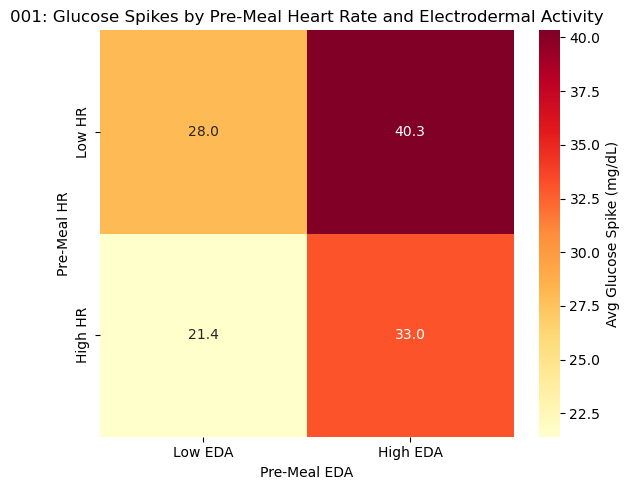

In [22]:
# Create pivot table
heatmap_data = biosignal_meals.pivot_table(
    values="glucose_spike",
    index=biosignal_meals["pre_hr"] >= biosignal_meals["pre_hr"].median(),
    columns=biosignal_meals["pre_eda"] >= biosignal_meals["pre_eda"].median(),
    aggfunc="mean"
)

# Label rows/columns
heatmap_data.index = heatmap_data.index.map({False: "Low HR", True: "High HR"})
heatmap_data.columns = heatmap_data.columns.map({False: "Low EDA", True: "High EDA"})

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    cbar_kws={'label': 'Avg Glucose Spike (mg/dL)'}
)
plt.title("001: Glucose Spikes by Pre-Meal Heart Rate and Electrodermal Activity")
plt.xlabel("Pre-Meal EDA")
plt.ylabel("Pre-Meal HR")
plt.tight_layout()

# plt.savefig("outputs/001_biosignal_spike_heatmap.png", dpi=300, bbox_inches="tight", pad_inches=0.5)
plt.show()

Now do this for ALL participants, not just `001`.

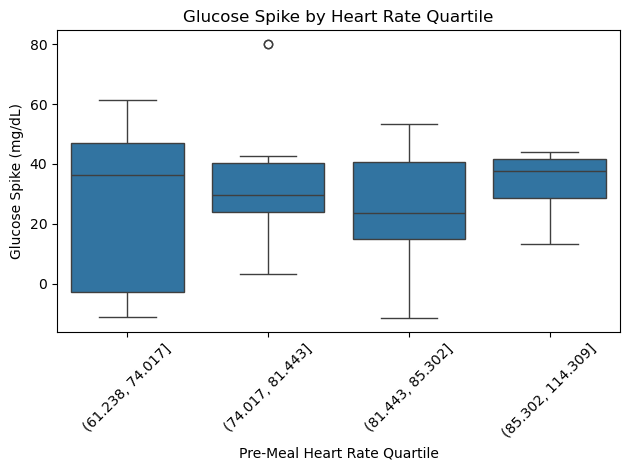

In [23]:
import seaborn as sns

# Bin HR or EDA into quantiles
biosignal_meals["hr_bin"] = pd.qcut(biosignal_meals["pre_hr"], q=4)
sns.boxplot(x="hr_bin", y="glucose_spike", data=biosignal_meals)
plt.title("Glucose Spike by Heart Rate Quartile")
plt.ylabel("Glucose Spike (mg/dL)")
plt.xlabel("Pre-Meal Heart Rate Quartile")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Meals eaten in the lowest HR state produced the largest and most variable glucose spikes, while moderate HR states had more stable responses.

Of course, this is only for participant `001`. Do this for ALL participants.

Let's try participant `009`.

### Participant 009

In [24]:
demo[demo['ID'] == 9] # prediabetic

,ID,Gender,HbA1c
10,9,MALE,6.1


In [25]:
# === Dexcom (Glucose) ===
dexcom_df = pd.read_csv("data/009/Dexcom_009.csv", skiprows=range(1, 13))
dexcom_df.columns = dexcom_df.columns.str.strip()
dexcom_df["datetime"] = pd.to_datetime(dexcom_df["Timestamp (YYYY-MM-DDThh:mm:ss)"], errors="coerce")
dexcom_df = dexcom_df.rename(columns={"Glucose Value (mg/dL)": "glucose"})
dexcom_df = dexcom_df[["datetime", "glucose"]].dropna()

In [26]:
# === Heart Rate ===
# Step 1: Load and clean column names
hr_df = pd.read_csv("data/009/HR_009.csv")
hr_df.columns = hr_df.columns.str.strip()

# Step 2: Convert datetime strings to actual datetime objects
hr_df["datetime"] = pd.to_datetime(hr_df["datetime"], errors="coerce")

# Step 3: Standardize the HR column name (assumes it's the second column)
hr_df = hr_df.rename(columns={hr_df.columns[1]: "hr"})

# Step 4: Floor to nearest minute (for consistent grouping)
hr_df["datetime"] = hr_df["datetime"].dt.floor("min")

# Step 5: Average HR per minute
hr_df = hr_df.groupby("datetime")["hr"].mean().reset_index()

# Preview the cleaned result
# hr_df.head()

In [27]:
# === Electrodermal Activity  ===
# Step 1: Load and strip column names
eda_df = pd.read_csv("data/009/EDA_009.csv")
eda_df.columns = eda_df.columns.str.strip()

# Step 2: Convert datetime column to actual datetime objects
eda_df["datetime"] = pd.to_datetime(eda_df["datetime"], errors="coerce")

# Step 3: Standardize the EDA column name (assumes it's the second column)
eda_df = eda_df.rename(columns={eda_df.columns[1]: "eda"})

# Step 4: Round to nearest minute
eda_df["datetime"] = eda_df["datetime"].dt.floor("min")

# Step 5: Average EDA per minute
eda_df = eda_df.groupby("datetime")["eda"].mean().reset_index()

# Preview
# eda_df.head()

In [28]:
# Step 1: Load food_log_tagged and group food items into meals
import json

with open("data/food_log_tagged.json") as f:
    food_data = json.load(f)

food_df = pd.DataFrame(food_data)
food_df["datetime"] = pd.to_datetime(food_df["datetime"], errors="coerce")

# Group by (ID, datetime) to define meals
grouped_meals = food_df.groupby(["ID", "datetime"]).agg({
    "time_begin": "first",
    "calorie": "sum",
    "total_carb": "sum",
    "dietary_fiber": "sum",
    "sugar": "sum",
    "protein": "sum",
    "total_fat": "sum",
    "tags": lambda x: sorted(set(tag for sublist in x if isinstance(sublist, list) for tag in sublist))
}).reset_index()

# Clean and parse time_begin
grouped_meals["time_begin"] = pd.to_datetime(grouped_meals["time_begin"], errors="coerce")

In [29]:
# Load flattened glucose data
with open("data/flattened_glucose.json") as f:
    glucose_data = json.load(f)

glucose_df = pd.DataFrame(glucose_data)
glucose_df["timestamp"] = pd.to_datetime(glucose_df["timestamp"], errors="coerce")

# Function to compute glucose spike
def compute_glucose_spike(pid, meal_time):
    window = glucose_df[(glucose_df["patient_id"] == pid) &
                        (glucose_df["timestamp"] >= meal_time - pd.Timedelta(minutes=30)) &
                        (glucose_df["timestamp"] <= meal_time + pd.Timedelta(minutes=120))]
    if window.empty:
        return None
    before = window[window["timestamp"] <= meal_time]["glucose"]
    after = window[window["timestamp"] > meal_time]["glucose"]
    if before.empty or after.empty:
        return None
    return after.max() - before.mean()

# Apply spike function to each meal
grouped_meals["glucose_spike"] = grouped_meals.apply(
    lambda row: compute_glucose_spike(row["ID"], row["time_begin"]),
    axis=1
)

# Drop meals without glucose spike info
spike_meals = grouped_meals.dropna(subset=["glucose_spike"]).copy()

In [30]:
# Initialize new columns
pre_hr_vals = []
pre_eda_vals = []

# For each meal, extract 30-min pre-window signals
for _, row in spike_meals.iterrows():
    start = row["time_begin"] - pd.Timedelta(minutes=30)
    end = row["time_begin"]

    hr_window = hr_df[(hr_df["datetime"] >= start) & (hr_df["datetime"] <= end)]
    eda_window = eda_df[(eda_df["datetime"] >= start) & (eda_df["datetime"] <= end)]

    pre_hr_vals.append(hr_window["hr"].mean() if not hr_window.empty else None)
    pre_eda_vals.append(eda_window["eda"].mean() if not eda_window.empty else None)

# Attach to the meal DataFrame
spike_meals["pre_hr"] = pre_hr_vals
spike_meals["pre_eda"] = pre_eda_vals

In [31]:
biosignal_meals = spike_meals.dropna(subset=["pre_hr", "pre_eda"]).copy()

In [32]:
# STEP 2: Compute medians
hr_thresh = biosignal_meals["pre_hr"].median()
eda_thresh = biosignal_meals["pre_eda"].median()

# Label quadrant
def label_quadrant(row):
    if row["pre_hr"] >= hr_thresh and row["pre_eda"] >= eda_thresh:
        return "High HR + High EDA"
    elif row["pre_hr"] >= hr_thresh:
        return "High HR + Low EDA"
    elif row["pre_eda"] >= eda_thresh:
        return "Low HR + High EDA"
    else:
        return "Low HR + Low EDA"

biosignal_meals["biosignal_quadrant"] = biosignal_meals.apply(label_quadrant, axis=1)

In [33]:
# STEP 3: Summarize spike data by quadrant
spike_summary = biosignal_meals.groupby("biosignal_quadrant")["glucose_spike"].agg(
    count="count",
    avg_spike="mean",
    std_spike="std"
).reset_index()

# Sort for readability
spike_summary = spike_summary.sort_values("avg_spike", ascending=False)

print(spike_summary)

   biosignal_quadrant  count  avg_spike  std_spike
0  High HR + High EDA     26  44.397436  29.993113
1   High HR + Low EDA     37  34.744144  31.546016
2   Low HR + High EDA     37  27.882883  33.428657
3    Low HR + Low EDA     25  24.000000  29.767657


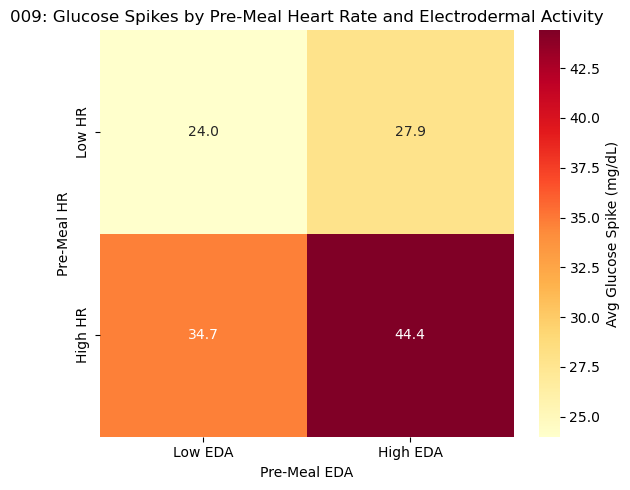

In [34]:
# Create pivot table
heatmap_data = biosignal_meals.pivot_table(
    values="glucose_spike",
    index=biosignal_meals["pre_hr"] >= biosignal_meals["pre_hr"].median(),
    columns=biosignal_meals["pre_eda"] >= biosignal_meals["pre_eda"].median(),
    aggfunc="mean"
)

# Label rows/columns
heatmap_data.index = heatmap_data.index.map({False: "Low HR", True: "High HR"})
heatmap_data.columns = heatmap_data.columns.map({False: "Low EDA", True: "High EDA"})

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    cbar_kws={'label': 'Avg Glucose Spike (mg/dL)'}
)
plt.title("009: Glucose Spikes by Pre-Meal Heart Rate and Electrodermal Activity")
plt.xlabel("Pre-Meal EDA")
plt.ylabel("Pre-Meal HR")
plt.tight_layout()

# plt.savefig("outputs/009_biosignal_spike_heatmap.png", dpi=300, bbox_inches="tight", pad_inches=0.5)
plt.show()

## 🔥 Participant 009: Glucose Spikes by Pre-Meal HR and EDA

### 👤 Participant Profile

| Attribute     | Value         |
|---------------|---------------|
| **ID**        | 009           |
| **Gender**    | Male          |
| **HbA1c**     | 6.1%          |
| **Status**    | 🟠 Prediabetic |

Participant 009 has an HbA1c of 6.1%, placing him in the **prediabetic range**. This suggests that his body may have **reduced insulin sensitivity** or difficulty handling blood glucose after meals — especially under physiologically demanding conditions.

---

### 📊 Heatmap: Average Glucose Spike (mg/dL) by Pre-Meal Physiological State

|               | **Low EDA**   | **High EDA**  |
|---------------|---------------|---------------|
| **Low HR**    | 24.0 mg/dL    | 27.9 mg/dL    |
| **High HR**   | 34.7 mg/dL    | **44.4 mg/dL** 🔥 |

---

### 🔍 Interpretation

- The **highest glucose spikes** occurred when both **HR and EDA were elevated** — a state that reflects combined **physical and emotional arousal**
- Even when only **HR was high**, spike values increased noticeably
- The **lowest spikes** occurred in calm, low-HR, low-EDA conditions

---

### 🧠 What This Tells Us

> For this participant with elevated HbA1c, meals eaten in **stressed or activated physiological states** produced **much higher glucose spikes** than meals eaten while calm.

This supports the hypothesis that:
- **Stress and exertion amplify glucose responses**, particularly in metabolically vulnerable individuals
- **Internal state before eating** may be just as important as meal content

---

### 📎 Comparison Context (optional)

Compared to Participant 001 (HbA1c = 5.5%), who showed **smaller and more stable glucose responses**, Participant 009 exhibits a **sharper biosignal-dependent modulation of glycemic spikes**. This reinforces the idea that **biosignals may interact with metabolic status** to shape postprandial outcomes.


🎥 Data Story (AND–BUT–THEREFORE)

    AND:
    People often focus on what they eat — calories, carbs, sugar — when trying to manage blood sugar.
    AND new wearable devices let us continuously measure internal physiological signals like heart rate (HR) and electrodermal activity (EDA), giving us insight into the state our body is in before we eat.

    BUT:
    What if it’s not just the meal, but the state you're in before the meal that affects how your body responds?
    Our exploratory analysis shows that even in a metabolically healthy individual (HbA1c = 5.5%), glucose spikes were significantly higher when EDA was elevated before eating.
    AND in a prediabetic participant (HbA1c = 6.1%), glucose spikes were amplified when both HR and EDA were high — a stressed and physically aroused state.

    THEREFORE:
    Biosignals like HR and EDA can help explain variability in post-meal glucose responses, even beyond what nutrition alone can predict.
    Understanding and integrating internal physiological state could be key to more personalized glucose management — not just for diabetics, but for anyone.

## **Pipeline**

In [35]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path


def load_clean_sensor_data(pid):
    base_path = Path(f"data/{pid}")

    # Dexcom
    dexcom = pd.read_csv(base_path / f"Dexcom_{pid}.csv", skiprows=range(1, 13))
    dexcom.columns = dexcom.columns.str.strip()
    dexcom["datetime"] = pd.to_datetime(dexcom["Timestamp (YYYY-MM-DDThh:mm:ss)"], errors="coerce")
    dexcom = dexcom.rename(columns={"Glucose Value (mg/dL)": "glucose"})
    dexcom = dexcom[["datetime", "glucose"]].dropna()

    # HR
    hr = pd.read_csv(base_path / f"HR_{pid}.csv")
    hr.columns = hr.columns.str.strip()
    hr = hr.rename(columns={hr.columns[1]: "hr"})
    hr["datetime"] = pd.to_datetime(hr["datetime"], errors="coerce").dt.floor("min")
    hr = hr.groupby("datetime")["hr"].mean().reset_index()

    # EDA
    eda = pd.read_csv(base_path / f"EDA_{pid}.csv")
    eda.columns = eda.columns.str.strip()
    eda = eda.rename(columns={eda.columns[1]: "eda"})
    eda["datetime"] = pd.to_datetime(eda["datetime"], errors="coerce").dt.floor("min")
    eda = eda.groupby("datetime")["eda"].mean().reset_index()

    return dexcom, hr, eda


def load_meal_and_glucose_logs():
    with open("data/food_log_tagged.json") as f:
        food_data = json.load(f)
    food_df = pd.DataFrame(food_data)
    food_df["datetime"] = pd.to_datetime(food_df["datetime"], errors="coerce")

    with open("data/flattened_glucose.json") as f:
        glucose_data = json.load(f)
    glucose_df = pd.DataFrame(glucose_data)
    glucose_df["timestamp"] = pd.to_datetime(glucose_df["timestamp"], errors="coerce")

    return food_df, glucose_df


def process_participant(pid, food_df, glucose_df, dexcom_df, hr_df, eda_df):
    # Meals for this participant
    grouped = food_df[food_df["ID"] == pid]
    grouped = grouped.groupby(["ID", "datetime"]).agg({
        "time_begin": "first",
        "calorie": "sum",
        "total_carb": "sum",
        "dietary_fiber": "sum",
        "sugar": "sum",
        "protein": "sum",
        "total_fat": "sum",
        "tags": lambda x: sorted(set(tag for sublist in x if isinstance(sublist, list) for tag in sublist))
    }).reset_index()
    grouped["time_begin"] = pd.to_datetime(grouped["time_begin"], errors="coerce")

    # Glucose spikes
    def compute_spike(meal_time):
        window = glucose_df[(glucose_df["patient_id"] == pid) &
                            (glucose_df["timestamp"] >= meal_time - pd.Timedelta(minutes=30)) &
                            (glucose_df["timestamp"] <= meal_time + pd.Timedelta(minutes=120))]
        if window.empty:
            return None
        before = window[window["timestamp"] <= meal_time]["glucose"]
        after = window[window["timestamp"] > meal_time]["glucose"]
        if before.empty or after.empty:
            return None
        return after.max() - before.mean()

    grouped["glucose_spike"] = grouped["time_begin"].apply(compute_spike)
    spike_meals = grouped.dropna(subset=["glucose_spike"]).copy()

    # Pre-meal biosignals
    pre_hr, pre_eda = [], []
    for _, row in spike_meals.iterrows():
        start, end = row["time_begin"] - pd.Timedelta(minutes=30), row["time_begin"]
        hr_win = hr_df[(hr_df["datetime"] >= start) & (hr_df["datetime"] <= end)]
        eda_win = eda_df[(eda_df["datetime"] >= start) & (eda_df["datetime"] <= end)]
        pre_hr.append(hr_win["hr"].mean() if not hr_win.empty else None)
        pre_eda.append(eda_win["eda"].mean() if not eda_win.empty else None)

    spike_meals["pre_hr"] = pre_hr
    spike_meals["pre_eda"] = pre_eda
    biosignal_meals = spike_meals.dropna(subset=["pre_hr", "pre_eda"]).copy()

    # Quadrant labeling
    hr_thresh = biosignal_meals["pre_hr"].median()
    eda_thresh = biosignal_meals["pre_eda"].median()

    def quadrant(row):
        if row["pre_hr"] >= hr_thresh and row["pre_eda"] >= eda_thresh:
            return "High HR + High EDA"
        elif row["pre_hr"] >= hr_thresh:
            return "High HR + Low EDA"
        elif row["pre_eda"] >= eda_thresh:
            return "Low HR + High EDA"
        else:
            return "Low HR + Low EDA"

    biosignal_meals["biosignal_quadrant"] = biosignal_meals.apply(quadrant, axis=1)

    return biosignal_meals


def plot_2x2_heatmap(df, pid):
    heatmap_data = df.pivot_table(
        values="glucose_spike",
        index=df["pre_hr"] >= df["pre_hr"].median(),
        columns=df["pre_eda"] >= df["pre_eda"].median(),
        aggfunc="mean"
    )
    heatmap_data.index = heatmap_data.index.map({False: "Low HR", True: "High HR"})
    heatmap_data.columns = heatmap_data.columns.map({False: "Low EDA", True: "High EDA"})

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".1f",
        cmap="YlOrRd",
        cbar_kws={'label': 'Avg Glucose Spike (mg/dL)'}
    )
    plt.title(f"{pid}: Glucose Spikes by Pre-Meal HR and EDA")
    plt.xlabel("Pre-Meal EDA")
    plt.ylabel("Pre-Meal HR")
    plt.tight_layout()
    output_path = Path("outputs") / f"{pid}_biosignal_spike_heatmap.png"
    output_path.parent.mkdir(exist_ok=True)
    plt.savefig(output_path, dpi=300, bbox_inches="tight", pad_inches=0.5)
    plt.show()

```

This code defines:
- `load_clean_sensor_data(pid)`
- `load_meal_and_glucose_logs()`
- `process_participant(...)`
- `plot_2x2_heatmap(...)`
```

Call it like this:
```python
food_df, glucose_df = load_meal_and_glucose_logs()
dexcom, hr, eda = load_clean_sensor_data("001")
bio_df = process_participant("001")
```

In [36]:
demo

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


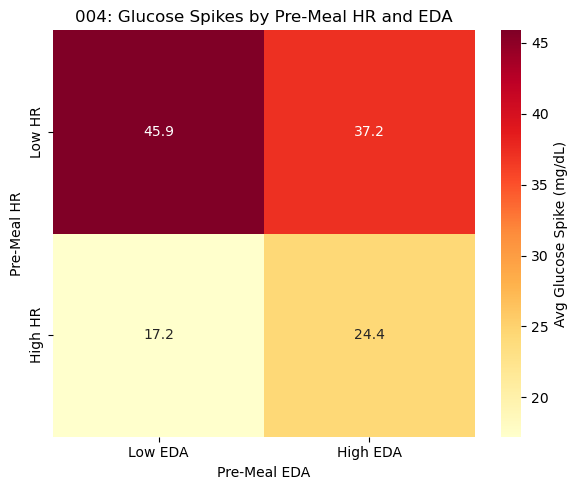

In [37]:
# Step 1: Load shared food and glucose logs
food_df, glucose_df = load_meal_and_glucose_logs()

# Step 2: Load participant 004’s sensor data
dexcom_df, hr_df, eda_df = load_clean_sensor_data("004")

# Step 3: Process meals and compute biosignal-spike matrix
biosignal_meals_004 = process_participant("004", food_df, glucose_df, dexcom_df, hr_df, eda_df)

# Step 4: Generate and save the 2x2 quadrant heatmap
plot_2x2_heatmap(biosignal_meals_004, "004")

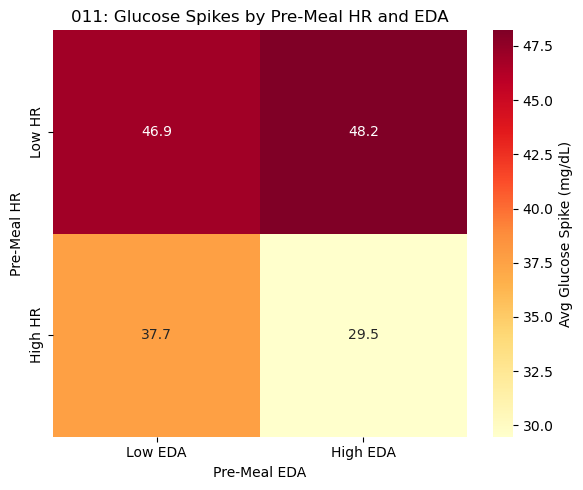

In [38]:
# Step 1: Load shared food and glucose logs
food_df, glucose_df = load_meal_and_glucose_logs()

# Step 2: Load participant 004’s sensor data
dexcom_df, hr_df, eda_df = load_clean_sensor_data("011")

# Step 3: Process meals and compute biosignal-spike matrix
biosignal_meals_004 = process_participant("011", food_df, glucose_df, dexcom_df, hr_df, eda_df)

# Step 4: Generate and save the 2x2 quadrant heatmap
plot_2x2_heatmap(biosignal_meals_004, "011")

In [39]:
participant_ids = [f"{i:03}" for i in range(1, 17)]

In [40]:
all_meals = []

for pid in participant_ids:
    try:
        dexcom, hr, eda = load_clean_sensor_data(pid)
        meals = process_participant(pid, food_df, glucose_df, dexcom, hr, eda)
        meals["participant_id"] = pid  # track who it came from
        all_meals.append(meals)
    except Exception as e:
        print(f"⚠️ Error with participant {pid}: {e}")

all_biosignal_meals = pd.concat(all_meals, ignore_index=True)

C:\Users\rsl\AppData\Local\Temp\ipykernel_29716\3186446173.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hr["datetime"] = pd.to_datetime(hr["datetime"], errors="coerce").dt.floor("min")


In [41]:
hr_thresh_all = all_biosignal_meals["pre_hr"].median()
eda_thresh_all = all_biosignal_meals["pre_eda"].median()

In [42]:
def label_quadrant(row, hr_thresh, eda_thresh):
    if row["pre_hr"] >= hr_thresh and row["pre_eda"] >= eda_thresh:
        return "High HR + High EDA"
    elif row["pre_hr"] >= hr_thresh:
        return "High HR + Low EDA"
    elif row["pre_eda"] >= eda_thresh:
        return "Low HR + High EDA"
    else:
        return "Low HR + Low EDA"

all_biosignal_meals["biosignal_quadrant"] = all_biosignal_meals.apply(
    lambda row: label_quadrant(row, hr_thresh_all, eda_thresh_all), axis=1
)

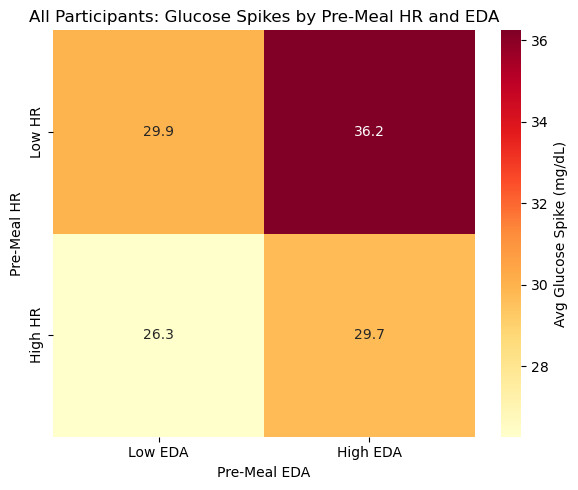

In [43]:
# Pivot the 2×2 table
heatmap_data = all_biosignal_meals.pivot_table(
    values="glucose_spike",
    index=all_biosignal_meals["pre_hr"] >= hr_thresh_all,
    columns=all_biosignal_meals["pre_eda"] >= eda_thresh_all,
    aggfunc="mean"
)

# Label rows and columns
heatmap_data.index = heatmap_data.index.map({False: "Low HR", True: "High HR"})
heatmap_data.columns = heatmap_data.columns.map({False: "Low EDA", True: "High EDA"})

heatmap_data = heatmap_data.apply(pd.to_numeric, errors="coerce")

# Plot it
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    cbar_kws={"label": "Avg Glucose Spike (mg/dL)"}
)
plt.title("All Participants: Glucose Spikes by Pre-Meal HR and EDA")
plt.xlabel("Pre-Meal EDA")
plt.ylabel("Pre-Meal HR")
plt.tight_layout()
plt.show()

In [44]:
summary_table = all_biosignal_meals.groupby("biosignal_quadrant")["glucose_spike"].agg(
    count="count",
    avg_spike="mean",
    std_spike="std"
).reset_index()

# Sort by average spike, descending
summary_table = summary_table.sort_values("avg_spike", ascending=False)

# Display the result
summary_table

,biosignal_quadrant,count,avg_spike,std_spike
2,Low HR + High EDA,100,36.245,31.224545
3,Low HR + Low EDA,120,29.936111,27.415869
0,High HR + High EDA,120,29.714683,22.796657
1,High HR + Low EDA,100,26.272,26.832305


### 🔬 Glucose Spikes by Biosignal Quadrant (All Participants)

| **Biosignal Quadrant**     | **Meal Count** | **Average Spike (mg/dL)** | **Std Dev** |
|----------------------------|----------------|----------------------------|-------------|
| Low HR + High EDA          | 100            | **36.25** 🔥               | 31.22       |
| Low HR + Low EDA           | 120            | 29.94                      | 27.42       |
| High HR + High EDA         | 120            | 29.71                      | 22.80       |
| High HR + Low EDA          | 100            | **26.27** 🧘               | 26.83       |


> **AND**:
Blood sugar response after eating varies from person to person.
AND wearable devices now let us track not just food and glucose, but also how our bodies feel right before we eat — using heart rate (HR) and electrodermal activity (EDA).

> **BUT**:
People often overlook that your internal state — whether you're calm, active, or stressed — may shape how your body handles that food.
Our analysis across 16 participants found that meals eaten during high EDA (stress/arousal) but low HR (rest) led to the largest glucose spikes on average.
Meanwhile, meals preceded by calm emotional state but light physical activity had the smallest spikes

> **THEREFORE**:
Glucose response is not just about what you eat — it's also about how your body is feeling when you eat.
Biosignals like HR and EDA could help personalize dietary advice and optimize metabolic health beyond carbs and calories.

### 📚 Scientific Literature Supporting the Impact of Stress and Activity on Glucose Spikes

| **Study** | **Key Finding** | **Link** |
|-----------|------------------|----------|
| Surwit et al. (1992), *Diabetes Care* | Psychological stress raises cortisol → higher glucose levels | [https://doi.org/10.2337/diacare.15.10.1413](https://doi.org/10.2337/diacare.15.10.1413) |
| Steptoe et al. (1997), *Psychosomatic Medicine* | Mental stress raises glucose even in healthy people | [https://pubmed.ncbi.nlm.nih.gov/9251160/](https://pubmed.ncbi.nlm.nih.gov/9251160/) |
| Black (2003), *Journal of Psychosomatic Research* | Sympathetic activation impairs insulin sensitivity | [https://doi.org/10.1016/S0022-3999(02)00629-4](https://doi.org/10.1016/S0022-3999(02)00629-4) |
| Mikus et al. (2012), *Diabetes Care* | Light physical activity before/after meals reduces spikes | [PubMed](https://pubmed.ncbi.nlm.nih.gov/22311420/) |
| Zeevi et al. (2015), *Cell* | Glucose response varies by lifestyle, physiology, microbiome | [https://doi.org/10.1016/j.cell.2015.11.001](https://doi.org/10.1016/j.cell.2015.11.001) |


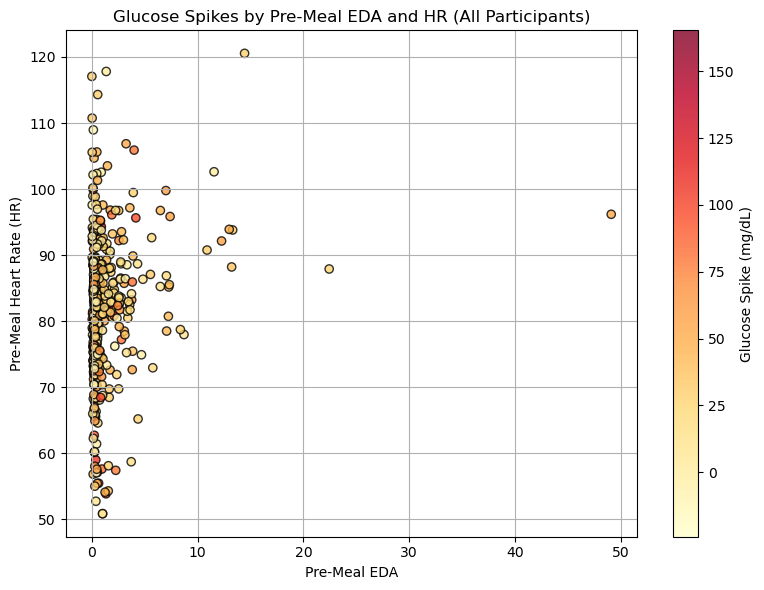

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop missing values just in case
scatter_data = all_biosignal_meals.dropna(subset=["pre_hr", "pre_eda", "glucose_spike"])

# Create the scatterplot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    scatter_data["pre_eda"],
    scatter_data["pre_hr"],
    c=scatter_data["glucose_spike"],
    cmap="YlOrRd",
    edgecolor="k",
    alpha=0.8
)+

# Add color bar and labels
cbar = plt.colorbar(scatter)
cbar.set_label("Glucose Spike (mg/dL)")

plt.xlabel("Pre-Meal EDA")
plt.ylabel("Pre-Meal Heart Rate (HR)")
plt.title("Glucose Spikes by Pre-Meal EDA and HR (All Participants)")
plt.grid(True)
plt.tight_layout()
plt.show()

Heart Rate (bpm): min = 50.85, max = 120.55
EDA (µS): min = 0.00, max = 49.10


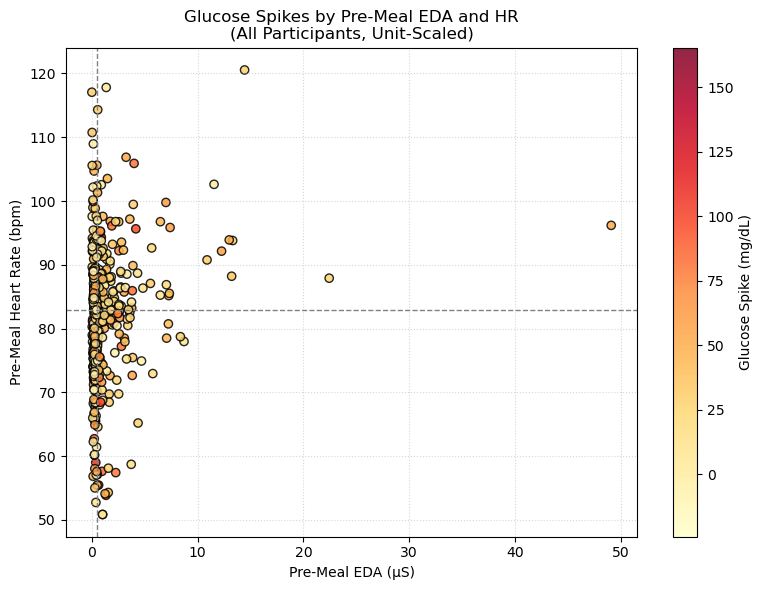

In [49]:
import matplotlib.pyplot as plt

# Drop missing data
scatter_data = all_biosignal_meals.dropna(subset=["pre_hr", "pre_eda", "glucose_spike"])

# Report range of values
hr_min, hr_max = scatter_data["pre_hr"].min(), scatter_data["pre_hr"].max()
eda_min, eda_max = scatter_data["pre_eda"].min(), scatter_data["pre_eda"].max()

print(f"Heart Rate (bpm): min = {hr_min:.2f}, max = {hr_max:.2f}")
print(f"EDA (µS): min = {eda_min:.2f}, max = {eda_max:.2f}")

# Medians for quadrant split
hr_median = scatter_data["pre_hr"].median()
eda_median = scatter_data["pre_eda"].median()

# Plot
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    scatter_data["pre_eda"],
    scatter_data["pre_hr"],
    c=scatter_data["glucose_spike"],
    cmap="YlOrRd",
    edgecolor="k",
    alpha=0.85
)

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label("Glucose Spike (mg/dL)")

# Axis labels with units
plt.xlabel("Pre-Meal EDA (µS)")
plt.ylabel("Pre-Meal Heart Rate (bpm)")

# Draw quadrant lines at medians
plt.axvline(x=eda_median, color="gray", linestyle="--", linewidth=1)
plt.axhline(y=hr_median, color="gray", linestyle="--", linewidth=1)

plt.title("Glucose Spikes by Pre-Meal EDA and HR\n(All Participants, Unit-Scaled)")
plt.grid(True, linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()


In [50]:
all_biosignal_meals

,ID,datetime,time_begin,calorie,total_carb,dietary_fiber,sugar,protein,total_fat,tags,glucose_spike,pre_hr,pre_eda,biosignal_quadrant,participant_id
0,001,2020-02-13 18:00:00,2020-02-13 18:00:00,456.0,85.0,1.7,83.0,16.0,3.3,"[drink, healthy, vegan, vegetarian]",80.0,77.217027,2.796193,Low HR + High EDA,001
1,001,2020-02-13 20:30:00,2020-02-13 20:30:00,488.0,2.5,1.2,0.8,63.4,23.1,"[dinner, entree, healthy, lunch, meat, snack, ...",-11.333333,82.534210,0.800621,Low HR + High EDA,001
2,001,2020-02-14 07:10:00,2020-02-14 07:10:00,230.0,35.0,0.0,18.0,13.0,0.0,"[breakfast, drink, healthy, snack, vegetarian]",26.833333,87.422419,1.791149,High HR + High EDA,001
3,001,2020-02-14 09:38:00,2020-02-14 09:38:00,280.0,30.0,0.0,22.0,4.0,0.0,"[breakfast, snack, vegan, vegetarian]",23.666667,85.004516,0.184064,High HR + Low EDA,001
4,001,2020-02-14 12:38:00,2020-02-14 12:38:00,358.0,14.4,0.0,8.7,13.9,0.0,"[breakfast, entree, healthy, lunch, snack, veg...",29.5,76.555161,0.171223,Low HR + Low EDA,001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,014,2020-06-12 06:05:00,2020-06-12 06:05:00,280.0,56.5,1.0,24.0,8.0,2.5,"[breakfast, snack]",100.333333,68.450855,0.831782,Low HR + High EDA,014
436,014,2020-06-12 09:10:00,2020-06-12 09:10:00,888.0,147.0,2.7,122.0,6.5,33.8,"[dessert, drink, healthy, snack, vegetarian]",37.0,87.761339,1.031274,High HR + High EDA,014
437,014,2020-06-12 12:45:00,2020-06-12 12:45:00,824.0,148.0,1.3,123.0,5.8,26.8,"[breakfast, dessert, drink, healthy, snack, ve...",72.166667,82.365645,2.445803,Low HR + High EDA,014
438,014,2020-06-12 17:15:00,2020-06-12 17:15:00,820.0,85.2,4.4,18.5,32.2,38.9,"[breakfast, drink, entree, snack, vegan, veget...",34.0,80.053538,0.249763,Low HR + Low EDA,014


In [57]:
all_biosignal_meals[all_biosignal_meals['ID'] == '015'].shape

(0, 15)

In [61]:
all_biosignal_meals['participant_id'].unique()

array(['001', '002', '004', '005', '006', '008', '009', '010', '011',
       '012', '014'], dtype=object)

In [63]:
type(all_biosignal_meals['time_begin'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [65]:
all_biosignal_meals = all_biosignal_meals.drop('participant_id', axis=1)

In [67]:
all_biosignal_meals = all_biosignal_meals.drop('time_begin', axis=1)

In [68]:
all_biosignal_meals

,ID,datetime,calorie,total_carb,dietary_fiber,sugar,protein,total_fat,tags,glucose_spike,pre_hr,pre_eda,biosignal_quadrant
0,001,2020-02-13 18:00:00,456.0,85.0,1.7,83.0,16.0,3.3,"[drink, healthy, vegan, vegetarian]",80.0,77.217027,2.796193,Low HR + High EDA
1,001,2020-02-13 20:30:00,488.0,2.5,1.2,0.8,63.4,23.1,"[dinner, entree, healthy, lunch, meat, snack, ...",-11.333333,82.534210,0.800621,Low HR + High EDA
2,001,2020-02-14 07:10:00,230.0,35.0,0.0,18.0,13.0,0.0,"[breakfast, drink, healthy, snack, vegetarian]",26.833333,87.422419,1.791149,High HR + High EDA
3,001,2020-02-14 09:38:00,280.0,30.0,0.0,22.0,4.0,0.0,"[breakfast, snack, vegan, vegetarian]",23.666667,85.004516,0.184064,High HR + Low EDA
4,001,2020-02-14 12:38:00,358.0,14.4,0.0,8.7,13.9,0.0,"[breakfast, entree, healthy, lunch, snack, veg...",29.5,76.555161,0.171223,Low HR + Low EDA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,014,2020-06-12 06:05:00,280.0,56.5,1.0,24.0,8.0,2.5,"[breakfast, snack]",100.333333,68.450855,0.831782,Low HR + High EDA
436,014,2020-06-12 09:10:00,888.0,147.0,2.7,122.0,6.5,33.8,"[dessert, drink, healthy, snack, vegetarian]",37.0,87.761339,1.031274,High HR + High EDA
437,014,2020-06-12 12:45:00,824.0,148.0,1.3,123.0,5.8,26.8,"[breakfast, dessert, drink, healthy, snack, ve...",72.166667,82.365645,2.445803,Low HR + High EDA
438,014,2020-06-12 17:15:00,820.0,85.2,4.4,18.5,32.2,38.9,"[breakfast, drink, entree, snack, vegan, veget...",34.0,80.053538,0.249763,Low HR + Low EDA


In [70]:
# Save the meal-level biosignal data as JSON for use in D3
all_biosignal_meals.to_json("all_biosignal_meals_tagged.json", orient="records", date_format="iso")